In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import os
import sys
from torch.utils.data import DataLoader

sys.path.append(os.path.abspath('../src'))
from data_tools.data_utils import ReportingDataset, create_data_split

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
project_dir = project_dir = Path.cwd().parent
device = 'mps'

In [2]:

trunc_D = 40


create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)
complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
max_val = complete_df.values.max()
print(max_val)


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


2904


In [3]:
y_true = complete_df.sum(axis=1)
y_true.index = pd.to_datetime(y_true.index)
y_true


Date_Symptoms
2013-02-09    1253
2013-02-10    1394
2013-02-11    1421
2013-02-12    1497
2013-02-13    1666
              ... 
2020-11-18     218
2020-11-19     211
2020-11-20     297
2020-11-21     223
2020-11-22     275
Length: 2844, dtype: int64

In [4]:
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
val_df = pd.read_csv(project_dir / "data" / "model" / "validation_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)


In [5]:

model_D = 40
M = 0
train_dataset = ReportingDataset(train_df, D=model_D, M=M, max_val=max_val)
val_dataset = ReportingDataset(val_df, D=model_D, M=M, max_val=max_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


print(train_dataset.__len__())

1990


In [9]:
from PNN.data_functions import get_dataset
model_D = 40
M = 0

dataset = get_dataset(weeks=False, triangle=True, past_units=M+model_D, max_delay=model_D, state='SP', dow=False, path=project_dir / "data" / "raw" / "DENGSP.csv")#, vector_y = True)


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/PNN/data_functions.py:109: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [7]:
from sklearn.model_selection import train_test_split as TTS
from PNN.train_utils import SubsetSampler as SS
from torch.utils.data.sampler import SubsetRandomSampler as SRS
import torch
import random

SEED = 1234
BATCH_SIZE = 64

all_idcs = range(dataset.__len__())
train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)

g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    
set_seeds(SEED)


In [12]:
from PNN.train_utils import train, EarlyStopper
from PNN.NowcastPNN import NowcastPNN

early_stopper = EarlyStopper(
    patience=30, past_units=M+model_D,
      max_delay=model_D, weeks=False,
        future_obs=0, random_split=False, dow = False
)
nowcast_pnn = NowcastPNN(past_units=M+model_D, max_delay=model_D, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1])


In [ ]:
train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = "mps", dow = False)


Epoch 1 - Train loss: 2.48e+05 - Val loss: 1.76e+06 - ES count: 0
Epoch 2 - Train loss: 2.37e+05 - Val loss: 1.68e+06 - ES count: 0
Epoch 3 - Train loss: 2.32e+05 - Val loss: 1.69e+06 - ES count: 1
Epoch 4 - Train loss: 2.24e+05 - Val loss: 1.76e+06 - ES count: 2
Epoch 5 - Train loss: 2.2e+05 - Val loss: 1.78e+06 - ES count: 3
Epoch 6 - Train loss: 2.15e+05 - Val loss: 1.69e+06 - ES count: 4
Epoch 7 - Train loss: 2.1e+05 - Val loss: 1.66e+06 - ES count: 0
Epoch 8 - Train loss: 2.04e+05 - Val loss: 1.56e+06 - ES count: 0
Epoch 9 - Train loss: 2e+05 - Val loss: 1.6e+06 - ES count: 1
Epoch 10 - Train loss: 1.94e+05 - Val loss: 1.51e+06 - ES count: 0
Epoch 11 - Train loss: 1.88e+05 - Val loss: 1.44e+06 - ES count: 0
Epoch 12 - Train loss: 1.83e+05 - Val loss: 1.45e+06 - ES count: 1
Epoch 13 - Train loss: 1.78e+05 - Val loss: 1.34e+06 - ES count: 0
Epoch 14 - Train loss: 1.72e+05 - Val loss: 1.36e+06 - ES count: 1
Epoch 15 - Train loss: 1.66e+05 - Val loss: 1.24e+06 - ES count: 0
Epoch 16 -

KeyboardInterrupt: 

In [12]:
train_sampler.__len__()

1599

In [13]:
import torch
nowcast_pnn.load_state_dict(torch.load(f"../src/outputs/weights/weights-{M+model_D}-{model_D}"))

# Put model in eval mode with dropout active
nowcast_pnn.eval()
nowcast_pnn.drop1.train()
nowcast_pnn.drop2.train()

# plot_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
plot_loader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)
matrix, y = next(iter(plot_loader))
matrix = matrix.to("cpu")
nowcast_pnn = nowcast_pnn.to("cpu")

n_samples = 1000
preds = np.zeros(shape=(dataset.__len__(), n_samples))
for i in range(n_samples):
    preds[:, i] = nowcast_pnn(matrix).sample().numpy()

preds_median = np.quantile(preds, 0.5, axis=1)


In [22]:
preds_lower = np.quantile(preds, 0.025, axis=1)
preds_upper = np.quantile(preds, 0.975, axis=1)

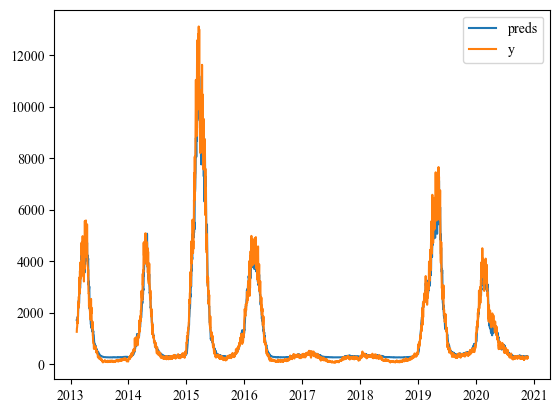

2844


In [21]:
plt.plot(y_true.index, preds_median, label='preds')
plt.plot(y_true.index, y.to("cpu"), label='y')
plt.legend()
plt.show()

print(len(y_true))

In [30]:
# write PNN preds to csv
PNN_preds = pd.DataFrame({
    'date': y_true.index,
    'preds': preds_median,
    'preds_lowers': preds_lower,
    'preds_upper': preds_upper,
    'true': y_true
})
PNN_preds.to_csv(project_dir / "data" / "model" / "PNN_results.csv", index=False)

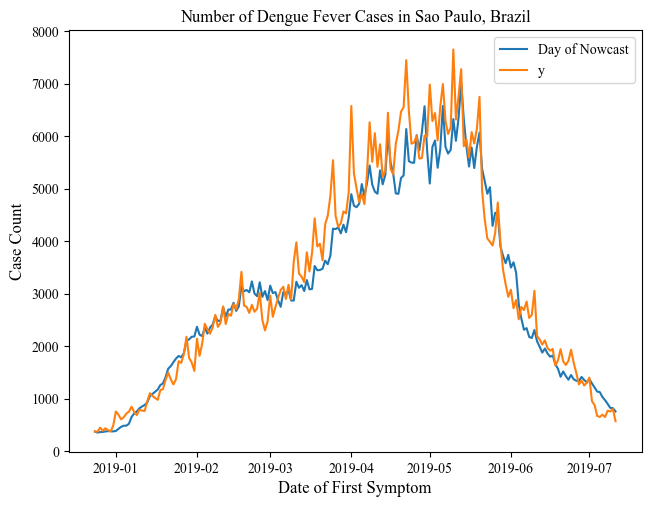

In [14]:
y_plot = y_true[-700:-500]
y_plot.index = pd.to_datetime(y_plot.index)
preds_plot = preds_median[-700:-500]

plt.plot(y_plot.index, preds_plot, label='Day of Nowcast')
plt.plot(y_plot.index, y_plot, label='y')
plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
# plt.xticks(rotation=45)
plt.show()

In [ ]:
def mask_matrix(matrix, D):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix


model_D = 40
M = 10
mask = np.ones((M + model_D, model_D), dtype=bool)
mask[-model_D:] = mask_matrix(mask[-model_D:], model_D)

y_label = []
lam_pred = []
dataset = get_dataset(weeks=False, triangle=True, past_units=M+model_D, max_delay=model_D, state='SP', dow=False, path=project_dir / "data" / "raw" / "DENGSP.csv")#, vector_y = True)

BNN_loader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)

In [48]:
from patsy import dmatrix
import numpy as np

def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

def silu(x):
    return x * pm.math.sigmoid(x)

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        tune=1000,
        target_accept=0.95,
        max_treedepth=15,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )


def get_model_nowcasts(reporting_triangle, data, D, mask):

    t = np.arange(0, data.shape[1])  # full time index
    t_week = t % 7                      # day of the week number

    print(t)
    # Global trend spline with 6 basis funcs and 3 degree polynomial
    spline_trend = dmatrix(
        "bs(t, df=10, degree=3, include_intercept=False)", {"t": t}, return_type='dataframe'
    )
    X_trend = np.asarray(spline_trend)

    # cc is syclic cubic spline
    spline_week = dmatrix(
        "cc(t_week, df=6)", {"t_week": t_week}, return_type='dataframe'
    )
    X_week = np.asarray(spline_week)


    with pm.Model() as model:

        # Trend spline coefficients
        sigma_trend = pm.HalfNormal("sigma_trend", 3)
        beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])
        
        # Cyclic spline coefficients (seasonality)
        sigma_week = pm.HalfNormal("sigma_week", 3)
        beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])
        
        log_lam = pm.Deterministic(
            "log_lam", pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week)
        )
        lam = pm.Deterministic("lam", pm.math.exp(pm.math.clip(log_lam, -5, 10)))


        # Neural net proportions
        T, MD, D = reporting_triangle.shape
        n_hidden = 8

        h0 = pm.math.flatten(reporting_triangle, ndim=2)  # (T, D*F)
        
        W1 = pm.Normal("W1", 0, 0.3, shape=(MD*D, n_hidden))
        b1_net = pm.Normal("b1_net", 0, 0.3, shape=(n_hidden,))
        h1 = silu(pm.math.dot(h0, W1) + b1_net)

        W2 = pm.Normal("W2", 0, 0.3, shape=(n_hidden, D))
        b2_net = pm.Normal("b2_net", 0, 0.3, shape=(D,))
        p_raw = pm.math.dot(h1, W2) + b2_net


        p_raw = pm.math.clip(p_raw, -10, 10)
        p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

        mu = pm.Deterministic("mu", lam[:, None] * p)
        mu_clipped = pm.math.clip(mu, 1e-3, 1e4)

        alpha = pm.Exponential("alpha", 5)
        z = pm.NegativeBinomial("z", mu_clipped[mask], alpha, observed=data[mask])

        idata = pm.sample(**sampler_kwargs())
        return(idata)



for matrix_batch, y_label_batch in BNN_loader:
    for t in range(1):
        print(t)
        reporting_triangle = matrix_batch[t]
        data = reporting_triangle * dataset.max_val
        print(data.shape)
        print(mask.shape)

        reporting_triangle = reporting_triangle.to("cpu").unsqueeze(0).numpy()
        data = data.to("cpu").numpy()
        ppc = get_model_nowcasts(reporting_triangle, data, model_D, mask)

        lam_post_samples = az.extract(ppc, group='posterior', num_samples=1000)['lam']
        lam_med = np.percentile(lam_post_samples, 50, axis=1)
        lam_pred.append(lam_med[-1])
        y_label.append(y_label_batch[t].to("cpu").numpy()[0])





0
torch.Size([50, 40])
(50, 40)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


Progress,Draws,Divergences,Step Size,Gradients/Draw
,0,0,0.00,0
,0,0,0.00,0


IndexError: index -1 is out of bounds for axis 0 with size 0

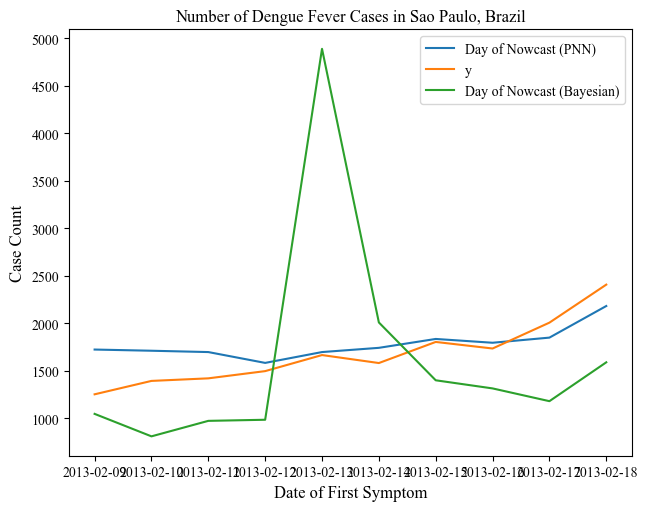

In [35]:

y_plot = y_true[0:10]
y_plot.index = pd.to_datetime(y_plot.index)
preds_plot = preds_median[0:10]

plt.plot(y_plot.index, preds_plot, label='Day of Nowcast (PNN)')
plt.plot(y_plot.index, y_plot, label='y')
plt.plot(y_plot.index, lam_pred, label='Day of Nowcast (Bayesian)')

plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
# plt.xticks(rotation=45)
plt.show()